In [1]:
import os,sys,glob,time
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.theory.auxiliaryFunctions import rescaleWidth, unscaleWidth
import numpy as np
from trimRegularGrid import trim1D, testTrimmedGrid, removeWidth, trimGrid
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.spatial import ConvexHull,Delaunay
from scipy.interpolate import griddata, LinearNDInterpolator
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
maxDiff=5e-2
minValue=1e-8
ds = SR = 'SR2FULL_150'
tx = 'THSCPM1b'

ntries = 1
gridSize = []
maxError = []
dataFile = '%s_eff_mutrig_%s.dat' %(tx,ds)
valueLabel = ds
#Get data
data = np.genfromtxt(dataFile,names=True)
if 'width' in data.dtype.names:
    data['width'] = np.array([rescaleWidth(w) for w in data['width']])

#Pre-select data:
data = data[(data['width'] < 40) & (data['mhscp'] < 200)]
data = data[(data['width'] > 20)]

In [36]:
xy = np.array([list(x) for x in data[['mhscp','width']]])
yvals = data[SR]
yvalsNorm = np.where(yvals > minValue,yvals,minValue)

In [40]:
def trimGridTest(points,values,minY = 1e-2,maxDiff = 5e-2,random=True,init_frac=0.1):

    t0 = time.time()

    #Replace all small values by minY:
    values = np.where(values > minY,values,minY)
    #Get triangulation:
    tri = Delaunay(points)
    #Get convex hull
    cHullvertices = list(set(tri.convex_hull.flatten()))
    #Get infor about neighbors:
    indptr,indices = tri.vertex_neighbor_vertices
    
    #First compute the maximum (relative) gradient at each point:
    gradients = []
    for i,pt in enumerate(tri.points):
        #Get the neighbors to the point
        neighbors = indices[indptr[i]:indptr[i+1]]
        #Compute the gradient in each direction:
        deltaY = np.abs(values[i]-values[neighbors])
        deltaX = np.array([np.linalg.norm(pt-tri.points[ii]) for ii in neighbors])
        grad = deltaY/deltaX
        gradients.append(grad.max()/values[i])
    gradients = np.array(gradients)
    
    #Get indices of points with the largest gradients coming first
    indexGrad = np.arange(len(points))[np.argsort(gradients)[::-1]]
    
    #Now start with the 10% points with largest gradient + convexHull:
    indexKeep = set(cHullvertices[:])
    indexKeep = indexKeep.union(indexGrad[:int(init_frac*len(points))])
    indexKeep = sorted(list(indexKeep))
    
    #Create an additional grid with possibility to adding points:
    triNew = Delaunay(points[indexKeep],incremental=True)
    valuesNew = values[indexKeep]
    indexKeep = set(indexKeep)
    
    #At each point check if interpolation at its original neighbors requires adding the neighbor:
    indexAdd = True        
    while indexAdd:
        print('Checking with %i points' %len(triNew.points),len(indexKeep))
        indexAdd = set()
        for i,j in enumerate(indexKeep):
            indptr_new,indices_new = triNew.vertex_neighbor_vertices
            original_neighbors = indices[indptr[j]:indptr[j+1]]
            new_neighbors = indices_new[indptr_new[i]:indptr_new[i+1]]
            
            #Do not check points exactly at the corners
            if len(new_neighbors) <= tri.points.shape[1]:
                continue
                
            linearF = LinearNDInterpolator(triNew.points[new_neighbors],valuesNew[new_neighbors])
            for og in original_neighbors:
                pt_og = tri.points[og]
                y_interp = max(minY,linearF(pt_og)[0]) #If interpolation is smaller than minY, set it to minY
                y = values[og]
                diff = abs(y_interp-y)/y #Relative difference
                if og == 129:
                    print('Checking',og,y_interp,y,diff)
                
                if diff > maxDiff and not og in indexKeep:
                    indexAdd.add(og)
                    triNew.add_points([pt_og])
                    valuesNew = np.hstack((valuesNew,[values[j]]))
        
        print('Adding',len(indexAdd))
        indexKeep = indexKeep.union(indexAdd)
                

    return list(indexKeep)


In [41]:
keepPts = trimGridTest(xy,yvals,maxDiff=0.05,minY=1e-8,random=False,init_frac=0.1)

Checking with 78 points 78
Checking 129 1e-08 1e-08 0.0
Checking 129 1e-08 1e-08 0.0
Adding 19
Checking with 144 points 97
Checking 129 1e-08 1e-08 0.0
Checking 129 1e-08 1e-08 0.0
Checking 129 1e-08 1e-08 0.0
Adding 0


In [32]:
tri = Delaunay(xy)
cHullvertices = list(set(tri.convex_hull.flatten()))
print(cHullvertices)

[0, 1, 2, 3, 153, 5, 6, 7, 8, 9, 10, 139, 140, 141, 142, 13, 12, 143, 11, 14, 15, 19, 20, 18, 24, 25, 26, 27, 28, 21, 22, 157, 160, 161, 158, 163, 164, 165, 166, 167, 154, 162, 159, 55, 56, 155, 16, 83, 84, 144, 17, 156, 145, 146, 147, 148, 4, 149, 111, 112, 150, 23, 151, 152]


In [37]:
newPts = xy[keepPts]
newVals = yvals[keepPts]
triNew = Delaunay(newPts)
cHullverticesNew = list(set(triNew.convex_hull.flatten()))
y_interp = griddata(newPts,newVals,tri.points)
y_interpNorm = np.where(y_interp > minValue, y_interp,minValue)

In [39]:
diffs = np.abs(y_interp-yvalsNorm)/yvalsNorm
print('max diff=',diffs.max())
print(np.argmax(diffs),y_interp[np.argmax(diffs)],yvals[np.argmax(diffs)])

max diff= 1.070939885907403
129 2.070939885907403e-08 2.4768084e-09


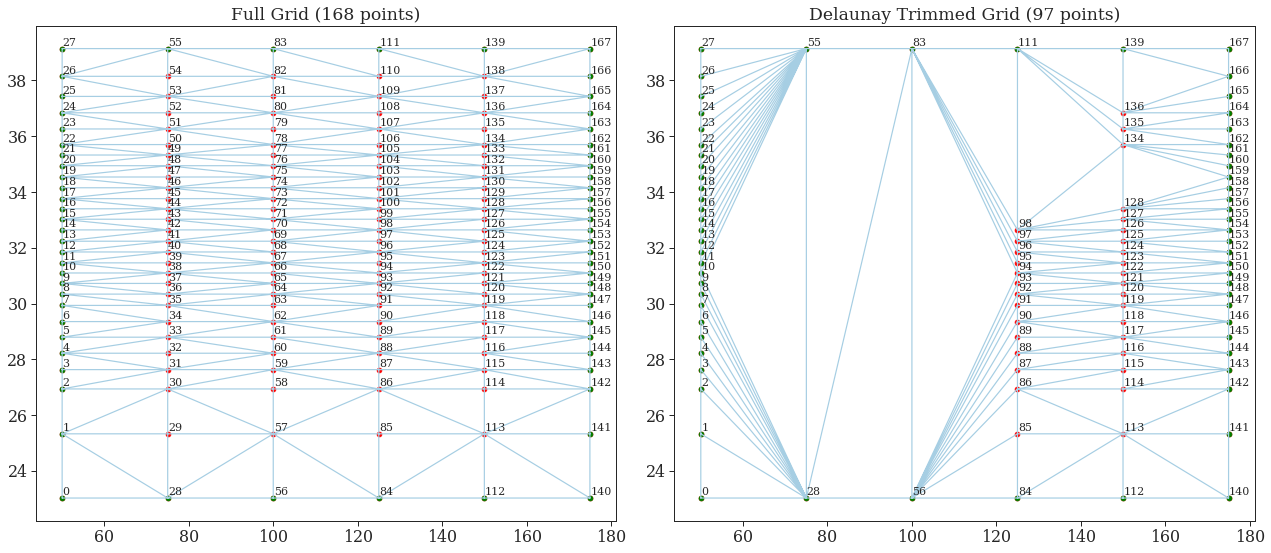

In [35]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))

ax[0].triplot(tri.points[:,0], tri.points[:,1], tri.simplices.copy())
ax[0].scatter(tri.points[:,0],tri.points[:,1],color='red')
ax[0].scatter(tri.points[cHullvertices][:,0],tri.points[cHullvertices][:,1],color='green')
for i,pt in enumerate(tri.points):
    ax[0].annotate('%i'%i,(pt[0]+0.1,pt[1]+0.1), fontsize=11)
ax[0].set_title('Full Grid (%i points)' %len(xy))    


ax[1].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[1].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
ax[1].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
for i in keepPts:
    ax[1].annotate('%i'%i,(tri.points[i][0]+0.1,tri.points[i][1]+0.1), fontsize=11)
ax[1].set_title('Delaunay Trimmed Grid (%i points)' %len(newPts))    

plt.tight_layout()
plt.show()

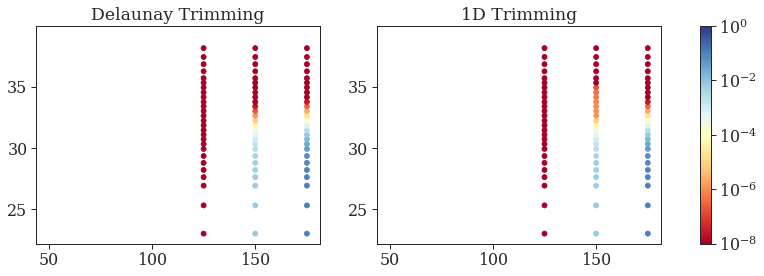

In [102]:
fig,ax = plt.subplots(ncols=2,figsize=(14,4))

ax[0].scatter(data['mhscp'],data['width'],c=yvals,s=25,cmap=cm, vmin=minValue,vmax=1.0,norm=LogNorm())
ax[0].set_title('Delaunay Trimming')
# ax[0].set_xlim(0,500)
# ax[0].set_ylim(20,40)


im = ax[1].scatter(data['mhscp'],data['width'],c=y_interp,s=25,cmap=cm, vmin=minValue,vmax=1.0,norm=LogNorm())
ax[1].set_title('1D Trimming')
# ax[1].set_xlim(0,500)
# ax[1].set_ylim(20,40)


fig.colorbar(im, ax=ax)
plt.show()

In [16]:
#Get infor about neighbors:
indptr,indices = tri.vertex_neighbor_vertices

#First compute the maximum (relative) gradient at each point:
gradients = []
for i,pt in enumerate(tri.points):
    #Get the neighbors to the point
    neighbors = indices[indptr[i]:indptr[i+1]]
    #Compute the gradient in each direction:
    deltaY = np.abs(yvals[i]-yvals[neighbors])
    deltaX = np.array([np.linalg.norm(pt-tri.points[ii]) for ii in neighbors])
    grad = deltaY/deltaX
    gradients.append([i,grad.max()])

#Sort according to largest gradients
gradients = np.array(gradients)
gradients = np.where(yvals > 0., gradients[:,1]/yvals, gradients[:,1]/minValue)


<ipython-input-16-131a773e0ccc>:17: RuntimeWarning: divide by zero encountered in true_divide
  gradients = np.where(yvals > 0., gradients[:,1]/yvals, gradients[:,1]/minValue)
<ipython-input-16-131a773e0ccc>:17: RuntimeWarning: invalid value encountered in true_divide
  gradients = np.where(yvals > 0., gradients[:,1]/yvals, gradients[:,1]/minValue)


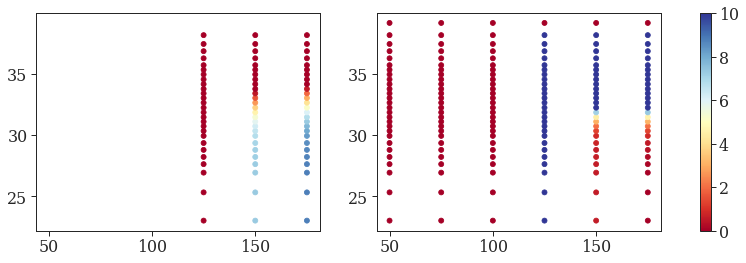

In [19]:
fig,ax = plt.subplots(ncols=2,figsize=(14,4))

ax[0].scatter(data['mhscp'],data['width'],c=yvals,s=25,cmap=cm, vmin=minValue,vmax=1.0,norm=LogNorm())
# ax[0].set_xlim(0,500)
# ax[0].set_ylim(20,40)


im = ax[1].scatter(data['mhscp'],data['width'],c=gradients,s=25,cmap=cm, vmin=0,vmax=10.0)
# ax[1].set_xlim(0,500)
# ax[1].set_ylim(20,40)


fig.colorbar(im, ax=ax)
plt.show()

In [25]:
x = np.array([1,3,2,5,7,4])
y = np.array(['a','c','b','e','f','d'])
y[np.argsort(x)[::-1][:3]]

array(['f', 'e', 'd'], dtype='<U1')